In [97]:
import pandas as pd
import numpy as np

In [108]:
images_train = 'data/train/train-jpg'
images_test = '.data/test/test-jpg'

labes_train = './data/train/train.csv'
labes_test = './data/test/test.csv'

In [99]:
data_train = pd.read_csv(labes_train)
data_test = pd.read_csv(labes_test)

In [100]:
data_train['image_name'] = data_train['image_name'].astype(str) + '.jpg'
data_test['image_name'] = data_test['image_name'].astype(str) + '.jpg'

In [101]:
#list of possible labels
data_test['tags'] = data_test['tags'].apply(lambda x: x.split(' '))

In [102]:
#separating images and labels
x_images_train = np.array(data_train['image_name'].tolist())
x_images_train.reshape((x_images_train.shape[0], 1))
labels_train = np.array(data_train['tags'].tolist())

In [103]:
labels = []
for tags in data_train['tags'].values:
    for tag in tags.split(' '):
        if tag not in labels:
            labels.append(tag)
labels.sort()

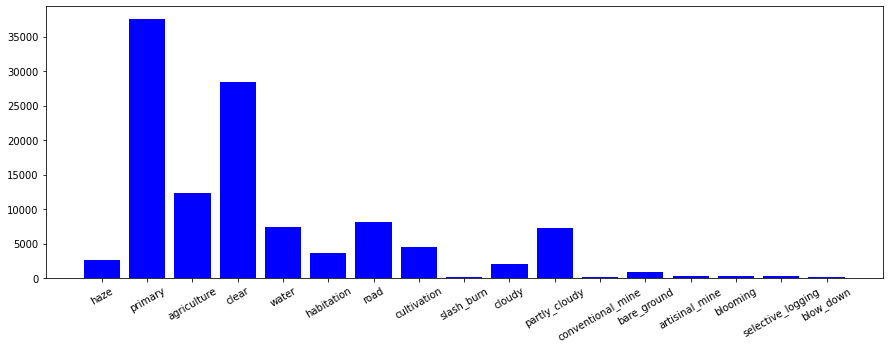

In [104]:
import matplotlib.pyplot as plt

# Dicionário para contagem de imagens por label
labels_count = {}

# Loop
for tag in data_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key = labels_count.get)
max_label = max(labels_count, key = labels_count.get)

plt.figure(figsize = (15, 5))

# Plot
plt.bar(range(len(labels_count)), list(labels_count.values()), align = 'center', color = 'blue')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation = 30)
plt.show()

In [105]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [106]:
training_transforms = transforms.Compose([transforms.Resize(64),
                                          transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(64),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(64),
                                            transforms.CenterCrop(64),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


In [109]:
images_train

'data/train/train-jpg'

In [110]:
training_dataset = datasets.ImageFolder(images_train, transform=training_transforms)
test_dataset = datasets.ImageFolder(images_test, transform=test_transforms)

FileNotFoundError: Couldn't find any class folder in data/train/train-jpg.